In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from typing import Tuple, List, Dict, Optional, Union
from torch import Tensor
import time

from pymatgen.analysis.diffraction.xrd import XRDCalculator

from pymatgen.transformations.standard_transformations import RotationTransformation
from pymatgen.io.cif import CifParser


# Detector Class

In [44]:
## final steps, rescale by magnitude (bc fully elastic scattering)
##magnitde is 2pi/wavelength so add wavelength into detector class
## rescale kfp and K_i bc qvector is kfp-K_i
dtype = torch.float32
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
class Detector:
    def __init__(self,X,Y,d_xy,R,wavelength,dtype=dtype,device=device):
        self.X = X #number of pixels
        self.Y = Y #number of pixels
        self.i_grid, self.j_grid = torch.meshgrid(torch.linspace(0,X-1,X, dtype = dtype, device=device), torch.linspace(Y-1,0,Y, dtype = dtype, device=device), indexing="ij") #specific pixle

        self.R = R #detector distance
        self.d_xy = d_xy #detector pixel size

        self.wavelength = wavelength #wavelength

    def get_alpha_i(self):
        alpha_i = torch.atan(self.d_xy/self.R*(self.i_grid-self.X/2))
        return alpha_i


    def get_alpha_j(self):
        alpha_j = torch.atan(self.d_xy/self.R*(self.j_grid-self.Y/2))
        return alpha_j


    def get_M1(self, K_i, K_f):

        self.K_i = K_i #wave vector incedent
        self.K_f = K_f #outgoing wave vector to center

        self.k_f_expand = K_f.view(1,1,3).expand(self.X, self.Y, 3)
        self.k_i_expand = K_i.view(1,1,3).expand(self.X, self.Y, 3)

        a_i = self.get_alpha_i()

        k_1 = torch.linalg.cross(self.K_i, self.K_f) / torch.norm(torch.linalg.cross(self.K_i, self.K_f))
        k_1_expand = k_1.view(1,1,3).expand(self.X, self.Y, 3)

    #defining the operations
        cos_ai = torch.cos(a_i).unsqueeze(-1)
        cross_k1_kf = torch.linalg.cross(k_1_expand, self.k_f_expand, dim = 2)
        sin_ai = torch.sin(a_i).unsqueeze(-1)
        dot_k1_kf = torch.dot(k_1, self.K_f)

        M1 = self.k_f_expand * cos_ai + cross_k1_kf * sin_ai + k_1_expand * dot_k1_kf * (1 - cos_ai)
        return M1


    def get_kfp(self, K_i, K_f):
        v = self.get_M1(K_i, K_f)
        k_2 = (self.K_f - self.K_i) / torch.norm(self.K_f - self.K_i)
        k_2_expand = k_2.view(1,1,3).expand(self.X, self.Y, 3)
        a_j = self.get_alpha_j()
  
  #defining the operations
        dot_prod = torch.sum(k_2_expand * v, dim = 2, keepdim = True)
        cos_aj = torch.cos(a_j).unsqueeze(-1)
        cross_k2_v = torch.linalg.cross(k_2_expand, v, dim=2)
        sin_aj = torch.sin(a_j).unsqueeze(-1)

        kfp = v * cos_aj + cross_k2_v * sin_aj + k_2 * dot_prod * (1 - cos_aj)
        return kfp
  
    def get_q(self, K_i, K_f):
        kfp = self.get_kfp(K_i, K_f)
        kfp_mag = kfp * 2 * torch.pi / self.wavelength
        K_i_mag = K_i * 2 * torch.pi / self.wavelength
        q = kfp_mag - K_i_mag
        return q

    @staticmethod
    def round_in_base(x: float, digits: int = 2, base: int = 10) -> float:
        """
        Round a number to the specified significant digits in the given base.
        Parameters:
        -----------
        x: float
            Number to round
        digits: int
            Number of significant digits to maintain when rounding
        base: int
            Base in which to round to the nearest power
        Returns:
        --------
        float:
            Rounded number
        """
        if x == 0:
            return 0
        else:
            exponent = np.floor(math.log(abs(x), base))
            scale = base ** (exponent - digits + 1)
            rounded = round(x / scale) * scale
            return type(x)(rounded)
        
    '''
    def calculate_resolution(self, K_i, K_f) -> float:
        q = self.get_q(K_i, K_f)
        q_max = q.max()
        res = 2 * torch.pi/q_max
        return res
    '''

    
        


# Sample Class

In [45]:
class Sample:
    """
    Class representing a crystal sample.
    """
    def __init__(
        self,
        cif_path: str,
        sample_size: Tuple[int, int, int],
        dtype: torch.dtype = torch.float32,
        device: str = 'mps'
    ):
        """
        Initialize a Sample object.
        Parameters:
        -----------
        cif_path: str
            Path to cif file
        sample_size: tuple
            Tuple of integers (n1, n2, n3) specifying crystal size in unit cells
        dtype: torch.dtype
            torch data type
        device: str
            torch device ('cuda' or 'cpu')
        """
        self.cif_path = cif_path
        self.sample_size = sample_size
        self.dtype = dtype
        self.device = device
 
    def parse_cif_file(self):
        parser = CifParser(self.cif_path)
        structure = parser.parse_structures(primitive=False)[0]
        #structure.make_supercell(self.sample_size)  ## Added this here, idk if it is the right place to add it
 
        return structure

 
    def calculate_sample_properties(self, structure):
        self.lattice_vectors = torch.tensor(structure.lattice.matrix * 1e-10, dtype=self.dtype, device=self.device)
        self.atom_positions = torch.tensor(structure.cart_coords * 1e-10, dtype=self.dtype, device=self.device)
        try: self.atom_types = list(map(str, map(lambda x: x.element, structure.species)))
        except: self.atom_types = list(map(str, structure.species))
        self.n_atoms = len(self.atom_types)
        self.n_cells = self.sample_size[0] * self.sample_size[1] * self.sample_size[2]
        self.cell_volume = torch.det(self.lattice_vectors).abs()
        self.sample_volume = self.cell_volume * self.n_cells
    def align_miller_plane_to_axis(self, structure, miller_indices, target_axis='x'):
        """
        Rotate a crystal structure so that the normal to a specified Miller plane
        is aligned with a target axis.
        Parameters:
        -----------
        structure : pymatgen.core.Structure
            The crystal structure to rotate
        miller_indices : tuple
            Miller indices (h, k, l) of the plane
        target_axis : str
            Target axis ('x', 'y', or 'z')
        Returns:
        --------
        rotated_structure : pymatgen.core.Structure
            The rotated structure
        """
        # Define target direction vectors
        target_directions = {
            'x': np.array([1, 0, 0]),
            'y': np.array([0, 1, 0]),
            'z': np.array([0, 0, 1])
        }
        if target_axis not in target_directions:
            raise ValueError("target_axis must be 'x', 'y', or 'z'")
        target_direction = target_directions[target_axis]
 
        # Get the reciprocal lattice
        reciprocal_lattice = structure.lattice.reciprocal_lattice
        # Calculate the normal vector to the Miller plane
        # Normal to (h,k,l) plane = h*a* + k*b* + l*c* (reciprocal lattice vectors)
        h, k, l = miller_indices
        miller_normal = (h * reciprocal_lattice.matrix[0] + 
                         k * reciprocal_lattice.matrix[1] + 
                         l * reciprocal_lattice.matrix[2])
        # Normalize the normal vector
        miller_normal = miller_normal / np.linalg.norm(miller_normal)
        # Calculate the rotation axis (cross product)
        rotation_axis = np.linalg.cross(miller_normal, target_direction)
        rotation_axis_norm = np.linalg.norm(rotation_axis)
        if rotation_axis_norm < 1e-10:  # Already aligned or anti-aligned
            if np.dot(miller_normal, target_direction) > 0:
                # Already aligned, no rotation needed
                return structure.copy()
            else:
                # Anti-aligned, need 180° rotation
                # Choose a perpendicular axis for 180° rotation
                rotation_axis = np.roll(target_direction, shift = 1)
                rotation_angle = np.pi
        else:
            rotation_axis = rotation_axis / rotation_axis_norm
            # Calculate rotation angle
            rotation_angle = np.arccos(np.clip(np.dot(miller_normal, target_direction), -1.0, 1.0))
        # Apply rotation transformation
        transformation = RotationTransformation(rotation_axis, rotation_angle, angle_in_radians=True)
        rotated_structure = transformation.apply_transformation(structure)
 
        return rotated_structure
    def get_atomic_form_factors(self) -> List[Tensor]:
        self.atomic_form_factors = {
            'O': [3.0485, 13.2771, 2.2868, 5.7011, 1.5463, 0.3239, 0.867, 32.9089, 0.2508],
            'Zn': [14.0743, 3.2655, 7.0318, 0.2333, 5.1652, 10.3163, 2.41, 58.7097, 1.3041],
            'Ba': [20.3361, 3.216, 19.297, 0.2756, 10.888, 20.2073, 2.6959, 167.202, 2.7731],
            'Ti': [9.7595, 7.8508, 7.3558, 0.5, 1.6991, 35.6338, 1.9021, 116.105, 1.2807],
            'Na': [4.7626, 3.285, 3.1736, 8.8422, 1.2674, 0.3136, 1.1128, 129.424, 0.676],
            'B':[2.0545, 23.2185, 1.3326, 1.021, 1.0979, 60.3498, 0.7068, 0.1403, -0.1932],
            'H':[0.489918, 20.6593, 0.262003, 7.74039, 0.196767, 49.5519, 0.049879, 2.20159, 0.001305]
        }
 
        self.coeff_a = torch.zeros((1, self.n_atoms, 4), dtype=self.dtype, device=self.device)
        self.coeff_b = torch.zeros((1, self.n_atoms, 4), dtype=self.dtype, device=self.device)
        self.coeff_c = torch.zeros((1, self.n_atoms), dtype=self.dtype, device=self.device)
        for i, atom_type in enumerate(self.atom_types):
            self.coeff_a[:,i] = torch.tensor(self.atomic_form_factors[atom_type][0:-1:2], dtype=self.dtype, device=self.device)
            self.coeff_b[:,i] = torch.tensor(self.atomic_form_factors[atom_type][1:-1:2], dtype=self.dtype, device=self.device)
            self.coeff_c[:,i] = torch.tensor(self.atomic_form_factors[atom_type][-1], dtype=self.dtype, device=self.device)
    def calculate_form_factors(self, q_magnitude: Tensor) -> Tensor:
        gaussians = self.coeff_a.view(1,-1) * torch.exp(-self.coeff_b.view(1,-1) * (q_magnitude / (4 * torch.pi)) ** 2)
        return gaussians.view(-1, self.n_atoms, 4).sum(dim=-1) + self.coeff_c

    def get_XRD(self, structure, xrd_wavelength='CuKa'):
        xrd_calc = XRDCalculator(wavelength=xrd_wavelength)
        pattern = xrd_calc.show_plot(structure)
        val = xrd_calc.get_pattern(structure)
        return pattern, val
        

# Scattering Class

$$A(q) = \frac{r_o\sqrt{\Phi_0}}{R}\sum_{R_n}\sum_{r_m} f_m(q)e^{-iq\cdot(R^m_n+u_m(R_n))}$$
$$\approx \frac{r_o\sqrt{\Phi_0}}{R}\prod_{i}d_i\sum_{R_{nd}}\sum_{r_m} f_m(q)e^{-iq\cdot(R^m_{dn}+\tilde{u}_m(R_{nd}))}$$

In [46]:
#start by generating a random list for spacing, and set form facter to 1 -> f
#u_tilde is ave displacement of atom m in the supercell at pos R_nd... we get these from the sample class above
# d_i are pos consant int values for each index i
#d_i goes 1, 2, 3
#d is size of super cell in each dim
#ni is diatance from or origin to lattice point
#pretend rm tilda for now
# Im just going to assume we know u_ave, R^m_dn and R_nd

class CoherentScattering:
    def __init__(self, sample, K_i, K_f, detector, dtype=dtype, device=device):
        self.K_i = K_i
        self.K_f = K_f
        self.detector = detector
        self.q_vectors = self.detector.get_q(K_i,K_f)
        self.sample = sample
        


    def calculate_structure_factor(self) -> Tensor:

            # Store original shape of q_vectors for later reshaping

        batch_size_original = self.q_vectors.shape[:-1]

            # Reshape q_vectors to [batch_size, 3] for matrix multiplication

        q_vectors_flat = self.q_vectors.reshape(-1, 3)

        batch_size = q_vectors_flat.shape[0]

            # Calculate q·r for each atom in the unit cell and each q-vector

            # q_vectors_flat shape: [batch_size, 3]

            # atom_positions shape: [n_atoms, 3]

            # result shape: [batch_size, n_atoms]

        q_dot_r = torch.matmul(q_vectors_flat, self.sample.atom_positions.T)

            # Calculate |q| for form factor (convert to Å for typical form factor formulas)

        q_magnitude = torch.sum(q_vectors_flat, dim=1, keepdim=True) * 1e-10  # [batch_size, 1]

 
            # Vectorized calculation of form factors for all atoms and all q values

        form_factors = self.sample.calculate_form_factors(q_magnitude)

            # Calculate e^(-iq·r) for each atom and each q-vector

            # Result shape: [batch_size, n_atoms]

        phase_factors = torch.exp(-1j * q_dot_r)

            # Multiply by form factors and sum over atoms

            # result shape: [batch_size]

        structure_factor = torch.sum(form_factors * phase_factors, dim=1)

            # Reshape back to original q_vectors shape

        structure_factor = structure_factor.view(batch_size_original)

        return(structure_factor)


    def R_sum(self,d):  # d and n should b tuples with 3 values

        
        d1, d2, d3 = d
        n1, n2, n3 = self.sample.sample_size

            # Generate supercell indices

        i_indices = torch.arange(0, n1, d1, dtype=dtype, device=device)
        j_indices = torch.arange(0, n2, d2, dtype=dtype, device=device)
        k_indices = torch.arange(0, n3, d3, dtype=dtype, device=device)

            # Compute a grid of all indices

        i, j, k = torch.meshgrid(i_indices, j_indices, k_indices, indexing='xy')
 
            # Reshape to [n_supercells, 3]

        supercell_indices = torch.stack([i.flatten(), j.flatten(), k.flatten()], dim=1)

            # Calculate positions in real space --> this is R_nd

        supercell_positions = torch.matmul(supercell_indices, self.sample.lattice_vectors) ## full grid of R_nd

            # Resizing q
    
        batch_size_original = self.q_vectors.shape[:-1]
        q_vectors_flat = self.q_vectors.reshape(-1, 3)
        batch_size = q_vectors_flat.shape[0]

            # Calculating dot_prod
    
        dot_prod_R = torch.matmul(q_vectors_flat, supercell_positions.T)

            # Finding the exponential component

        phase_R = torch.exp(-1j * dot_prod_R)

        R_comp = torch.sum(phase_R, dim=1)

        final_R = R_comp.view(batch_size_original)*d1*d2*d3

        return(final_R) 

    
    def get_intensity(self,d):

        q = self.q_vectors

        I = self.R_sum(d)*self.calculate_structure_factor()
        return I.abs()**2

    '''

    ## This max_intensity DOES NOT calculate R from scratch

    def max_intensity(self, R, d_xy, beta, rotated_structure):

        self.sample.calculate_sample_properties(rotated_structure) 

        N = self.sample.n_cells

        return(self.calculate_structure_factor()**2 * N**2 / R**2)

    ## The max_intensity function below calculates R from scratch, this should be used if we do not have a defined R

   '''     

    def max_intensity(self, rotated_structure):

        R = self.detector.R
        
        self.sample.calculate_sample_properties(rotated_structure) 

        N = self.sample.n_cells

        S = self.calculate_structure_factor()
        
        return(S.abs()**2 * N**2 / R**2)


    
        
        

# Scattering with Dislocation

In [47]:
# THIS IS SCATTERING WITH ADDED DISLOCATIONS


class CoherentScattering_dislocate:
    def __init__(self, sample, K_i, K_f, detector, dtype=dtype, device=device):
        self.K_i = K_i
        self.K_f = K_f
        self.detector = detector
        self.q_vectors = self.detector.get_q(K_i,K_f)
        self.sample = sample
        
    def get_dislocations(self,scale):
        #scale should be size in m
        u = torch.randn(self.sample.sample_size + self.sample.atom_positions.shape, device = device) * scale ##this creates a dislocation field
        return u    

    def calculate_sum(self,d,scale) -> Tensor:
        q_vectors_flat = self.q_vectors.reshape(-1, 3)  # [batch_size, 3]
        
        batch_size_original = self.q_vectors.shape[:-1]

        # Supercell positions R_nd
        d1, d2, d3 = d
        n1, n2, n3 = self.sample.sample_size

        i_indices = torch.arange(0, n1, d1, dtype=dtype, device=device)
        j_indices = torch.arange(0, n2, d2, dtype=dtype, device=device)
        k_indices = torch.arange(0, n3, d3, dtype=dtype, device=device)

            # Compute a grid of all indices

        i, j, k = torch.meshgrid(i_indices, j_indices, k_indices, indexing='xy')
 
            # Reshape to [n_supercells, 3]

        supercell_indices = torch.stack([i.flatten(), j.flatten(), k.flatten()], dim=1)

            # Calculate positions in real space --> this is R_nd

        #This is our R_nd comp

        supercell_positions = torch.matmul(supercell_indices, self.sample.lattice_vectors) ## full grid of R_nd


        #This is our r_m comp
       

        r_m = self.sample.atom_positions
        
        
        n_atoms = r_m.shape[0]

        # Average displacements u_m
        
        u_full = self.get_dislocations(scale)                                                   # [nx, ny, nz, n_atoms, 3]
        
        nx, ny, nz, _, _ = u_full.shape

        assert (n1 % d1 == 0) and (n2 % d2 == 0) and (n3 % d3 == 0)

        u = u_full.view(
            nx // d1, d1,
            ny // d2, d2,
            nz // d3, d3,
            n_atoms, 3
        )
        u_avg = u.mean(dim=(1, 3, 5))                                                       # [sx, sy, sz, n_atoms, 3]
        u_avg = u_avg.reshape(-1, n_atoms, 3)                                               # [n_supercells, n_atoms, 3]

        

        # Form factors (broadcasted)
        q_magnitude = torch.norm(q_vectors_flat, dim=1, keepdim=True) * 1e-10               # [batch_size, 1]
        
        
        f_q = self.sample.calculate_form_factors(q_magnitude)                               # [batch_size, n_atoms]
        f_q = f_q[:, None, :]                                                         # [batch_size, 1, n_atoms]
        
        

        # Reshape everything for broadcasting
        #q = q_vectors_flat[:, None, None, :]                                          # [batch_size, 1, 1, 3]
        #R = supercell_positions[ :, None, :]                                          # [n_supercells, 1, 3]
        r = r_m[None, :, :]                                                           # [1,n_atoms, 3]
        u = u_avg[:, :, :]                                                            # [ n_supercells, n_atoms, 3]

        #Summing the m dependant components
        
        m_dep_pos = r + u                                                               # [n_supercells, n_atoms, 3]
    

        q_dot_m = torch.einsum('bi,sai->bsa',q_vectors_flat, m_dep_pos)
        #q_dot_pos = torch.sum(q * total_pos, dim=-1) #Don't trust                            # [batch_size, n_supercells, n_atoms]
        m_dep_phase = torch.exp(-1j*q_dot_m)
        m_structure_factor = f_q * m_dep_phase

        m_sum = torch.sum(m_structure_factor, dim = -1)                                # [batch_size, n_supercells]

        q_dot_R = torch.matmul(q_vectors_flat, supercell_positions.T)             #[batch_size, n_supercells]
        
        R_phase = torch.exp(-1j * q_dot_R)

        ## Summing over Rnd

        tot_sum = torch.sum(m_sum * R_phase, dim = 1) * d1 * d2 * d3
        
        return tot_sum.view(batch_size_original)
        
    def get_intensity(self,d, scale):
        
        I = self.calculate_sum(d,scale) 

        return I.abs()**2


        

# Testing Scatter

In [48]:
a = 3.25e-10
c = 5.2e-10
 
sample = Sample(
    'BaTiO3.cif',
    sample_size = (100, 100, 100),
    dtype = dtype,
    device = device
)
 
structure = sample.parse_cif_file()
rotated_structure = sample.align_miller_plane_to_axis(structure, (1,1,0), target_axis='x')
sample.calculate_sample_properties(rotated_structure)
sample.get_atomic_form_factors()
lengths = sample.lattice_vectors.norm(dim=1)
print('Sample size:', ' nm x '.join('{:.1f}'.format(sample.sample_size[i] * lengths[i] * 1e9) for i in range(len(lengths))), 'nm')

Sample size: 40.1 nm x 40.1 nm x 40.1 nm


In [49]:
## R value is coming out suspicoiusly small right now, I think my N might be off
def get_R(sample, beta, rotated_structure, wavelength, d_xy):
        
    sample.calculate_sample_properties(rotated_structure) 

    N = sample.n_cells
        
    lattice_vectors = rotated_structure.lattice.matrix
        
    a1, a2, a3 = lattice_vectors  # each is a 3-element NumPy array
        # this is in hkl
    a1_m = a1 * 1e-10  # now in meters

    a_norm = np.linalg.norm(a1_m)


    k = 2*torch.pi / wavelength # can also get this using the k_i/f vals

    R = d_xy * beta * k * (N**(1/3)) * a_norm / torch.pi

    return R

In [50]:
wavelength = 1.5406e-10 #m

R = get_R(sample = sample, beta = 5, rotated_structure = rotated_structure, wavelength = wavelength, d_xy = 50e-6)
print(R)

0.13006885758795272


In [51]:


theta_B = torch.deg2rad(torch.torch.tensor(15.79, dtype=dtype, device = device)) 
k_i = torch.tensor([torch.sin(-theta_B), 0.0, torch.cos(-theta_B)], dtype=dtype, device=device)
k_f = torch.tensor([torch.sin(theta_B), 0., torch.cos(theta_B)], dtype=dtype, device=device)
scattering = CoherentScattering_dislocate(sample = sample,
                                K_i = k_i,
                                K_f = k_f,
                                detector = Detector(
                                    X = 128,
                                    Y = 128,
                                    d_xy = 50e-6,
                                    R = R,
                                    #R = 0.3946,
                                    wavelength = wavelength,
                                    dtype=dtype,
                                    device=device
                                ),
                                dtype=dtype,
                                device=device)
print(scattering.calculate_sum(d=(5,5,5), scale = 1e-10).shape)
t0 = time.time()
inten = scattering.get_intensity(d=(5,5,5), scale = 1e-10) # n changes the pattern, higher n makes it looks zoomed out  
print(time.time() - t0)


torch.Size([128, 128])
0.02036595344543457


In [52]:
scattering_perf = CoherentScattering(sample = sample,
                                K_i = k_i,
                                K_f = k_f,
                                detector = Detector(
                                    X = 128,
                                    Y = 128,
                                    d_xy = 50e-6,
                                    R = R,
                                    #R = 0.3946,
                                    wavelength = wavelength,
                                    dtype=dtype,
                                    device=device
                                ),
                                dtype=dtype,
                                device=device)
inten_perf = scattering_perf.get_intensity(d=(5,5,5)) # n changes the pattern, higher n makes it looks zoomed out  



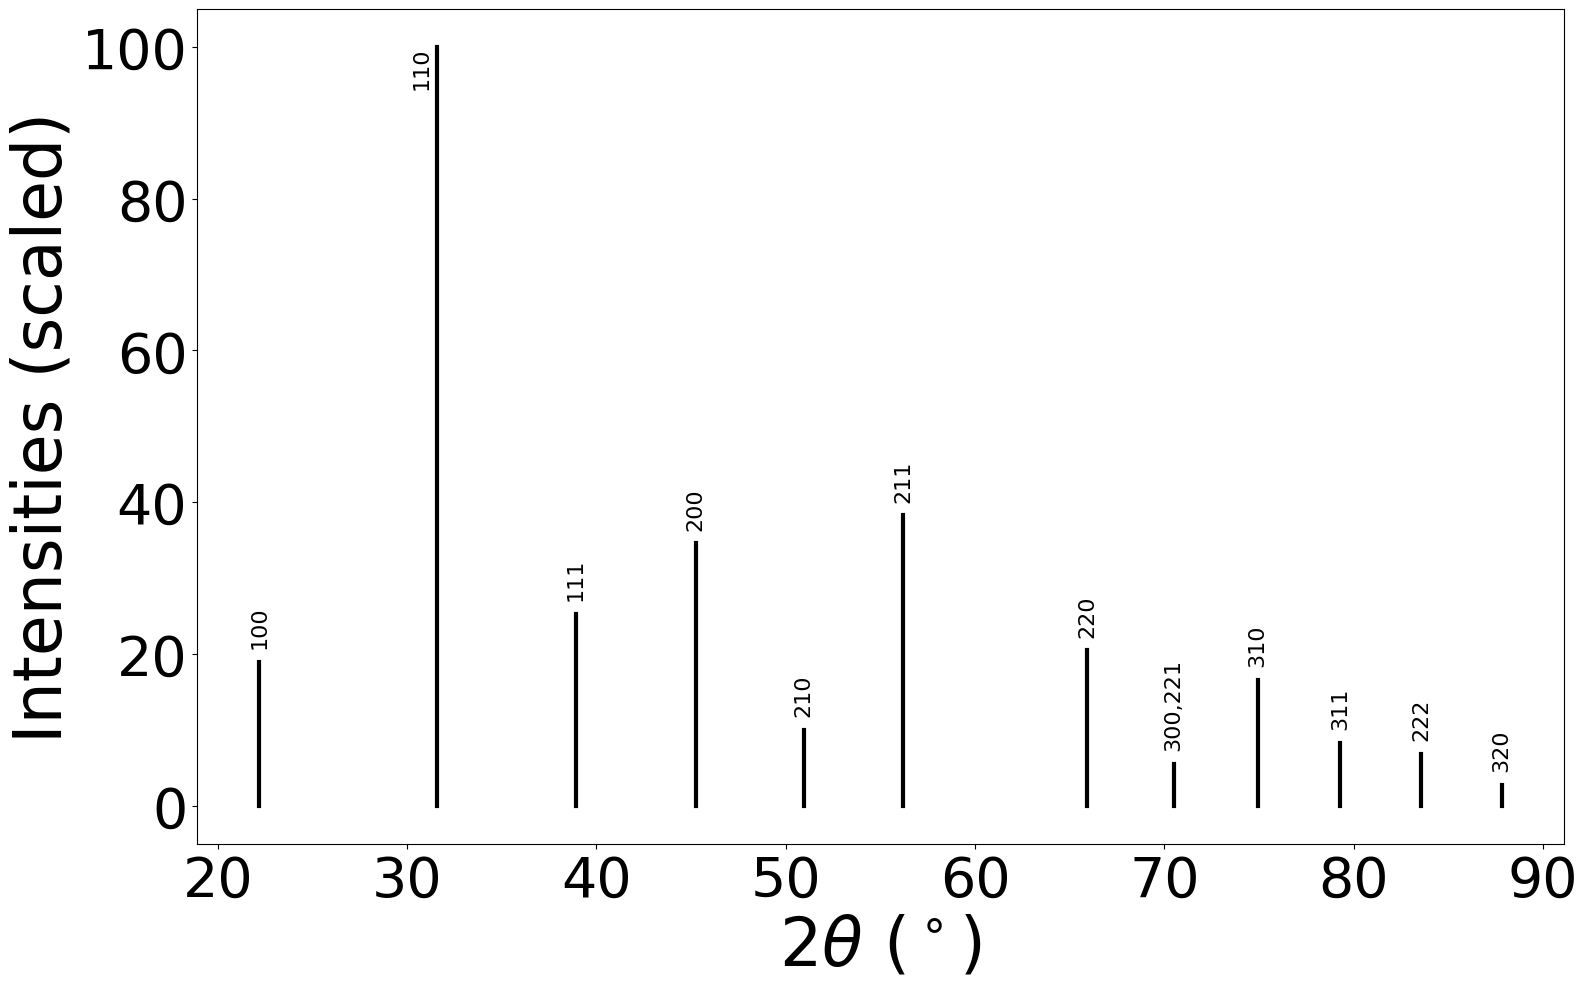

In [53]:
pattern, val = sample.get_XRD(structure)
plt.show()

In [54]:
scattering.sample.atom_positions.shape

torch.Size([5, 3])

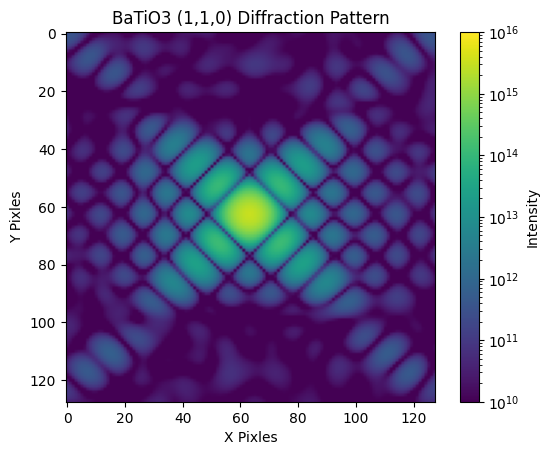

In [55]:
## Should prob experiment with adding Possion or Gaussian noise

#(could also be fun to see if neural net could work with noisier and noiser perfect diffraction data)
#vmax = Detector.round_in_base(inten.max().item(), digits = 1)
#vmin = vmax/1e5

plt.imshow(inten.cpu(),norm=colors.LogNorm(vmax = 1e16, vmin = 1e10))
plt.xlabel("X Pixles")
plt.ylabel("Y Pixles")
plt.title("BaTiO3 (1,1,0) Diffraction Pattern")
cbar = plt.colorbar()
cbar.set_label("Intensity")
plt.show()

## Acts as I expect it to when disclocations are very small, but as they get larger the pattern essentially just gets more grainy, that's it
# and not significantly more grainy as it gets unreasonably large

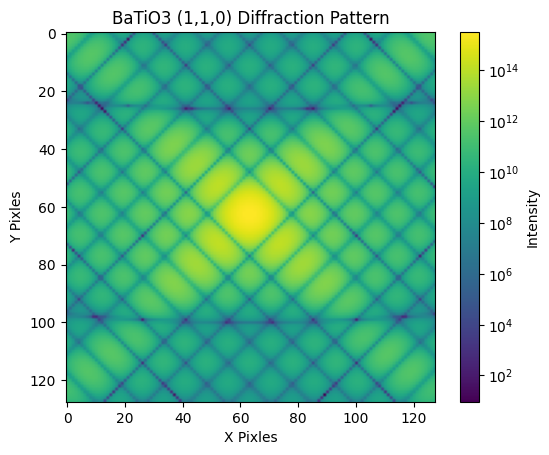

In [56]:
plt.imshow(inten_perf.cpu(),norm=colors.LogNorm())
plt.xlabel("X Pixles")
plt.ylabel("Y Pixles")
plt.title("BaTiO3 (1,1,0) Diffraction Pattern")
cbar = plt.colorbar()
cbar.set_label("Intensity")
plt.show()

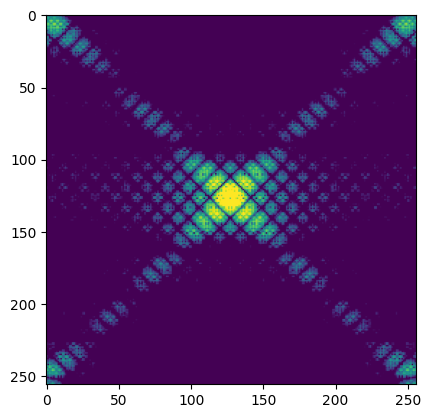

In [95]:
gaussian_noise = np.random.normal(1e-4, 1e-4, inten.shape)
plt.imshow(inten.cpu()+torch.from_numpy(gaussian_noise), norm=colors.LogNorm(vmin = 1e+11, vmax = 1e+15))

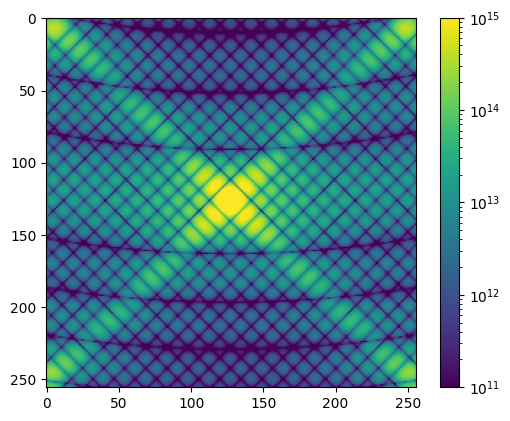

In [57]:
poisson_noise = torch.sqrt(inten.cpu()) * torch.from_numpy(np.random.normal(1e-6, 2e-8, inten.shape))
noisy_pattern = inten.cpu() + poisson_noise
plt.imshow(noisy_pattern, norm=colors.LogNorm(vmin = 1e+11, vmax = 1e+15)) ## trying to change plotting
plt.colorbar()
plt.show()

# Max Intensity Test

In [13]:
I_max = scattering.max_intensity(rotated_structure = rotated_structure) ## I have no clue how to plot this

In [14]:
I_max.shape

torch.Size([256, 256])

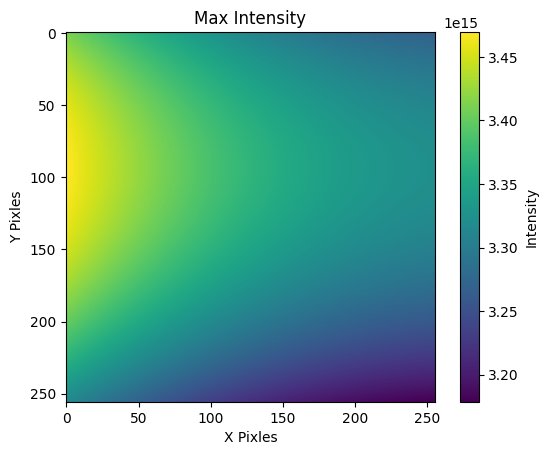

In [15]:
plt.imshow(I_max.cpu()) ## trying to change plotting
plt.xlabel("X Pixles")
plt.ylabel("Y Pixles")
plt.title("Max Intensity")
cbar = plt.colorbar()
cbar.set_label("Intensity")
plt.show()

# $$Na(BH)_5$$

In [67]:
sample_NaBH = Sample(
    'Na(BH)5.cif',
    sample_size = (100, 100, 100),
    dtype = dtype,
    device = device
)
 
structure_Na = sample_NaBH.parse_cif_file()
rotated_structure_Na = sample_NaBH.align_miller_plane_to_axis(structure_Na, (0,2,1), target_axis='x')
sample_NaBH.calculate_sample_properties(rotated_structure_Na)
sample_NaBH.get_atomic_form_factors()
lengths_Na = sample_NaBH.lattice_vectors.norm(dim=1)
print('Sample size:', ' nm x '.join('{:.1f}'.format(sample_NaBH.sample_size[i] * lengths_Na[i] * 1e9) for i in range(len(lengths_Na))), 'nm')

Sample size: 67.4 nm x 133.4 nm x 122.7 nm


In [68]:
wavelength = 1.5406e-10 #m

R_Na = get_R(sample = sample, beta = 5, rotated_structure = rotated_structure, wavelength = wavelength, d_xy = 50e-6)
print(R_Na)

0.13006885758795272


In [69]:
theta_B = torch.deg2rad(torch.torch.tensor(7.834377355, dtype=dtype, device = device)) 
k_i = torch.tensor([torch.sin(-theta_B), 0.0, torch.cos(-theta_B)], dtype=dtype, device=device)
k_f = torch.tensor([torch.sin(theta_B), 0., torch.cos(theta_B)], dtype=dtype, device=device)
scattering_NaBH = CoherentScattering(sample = sample_NaBH,
                                K_i = k_i,
                                K_f = k_f,
                                detector = Detector(
                                    X = 256,
                                    Y = 256,
                                    d_xy = 50e-6,
                                    R = R_Na,
                                    #R = 0.3946,
                                    wavelength = wavelength,
                                    dtype=dtype,
                                    device=device
                                ),
                                dtype=dtype,
                                device=device)
t0 = time.time()
inten_Na = scattering_NaBH.get_intensity(d=(6,6,6)) # n changes the pattern, higher n makes it looks zoomed out  
print(time.time() - t0)


0.0043718814849853516


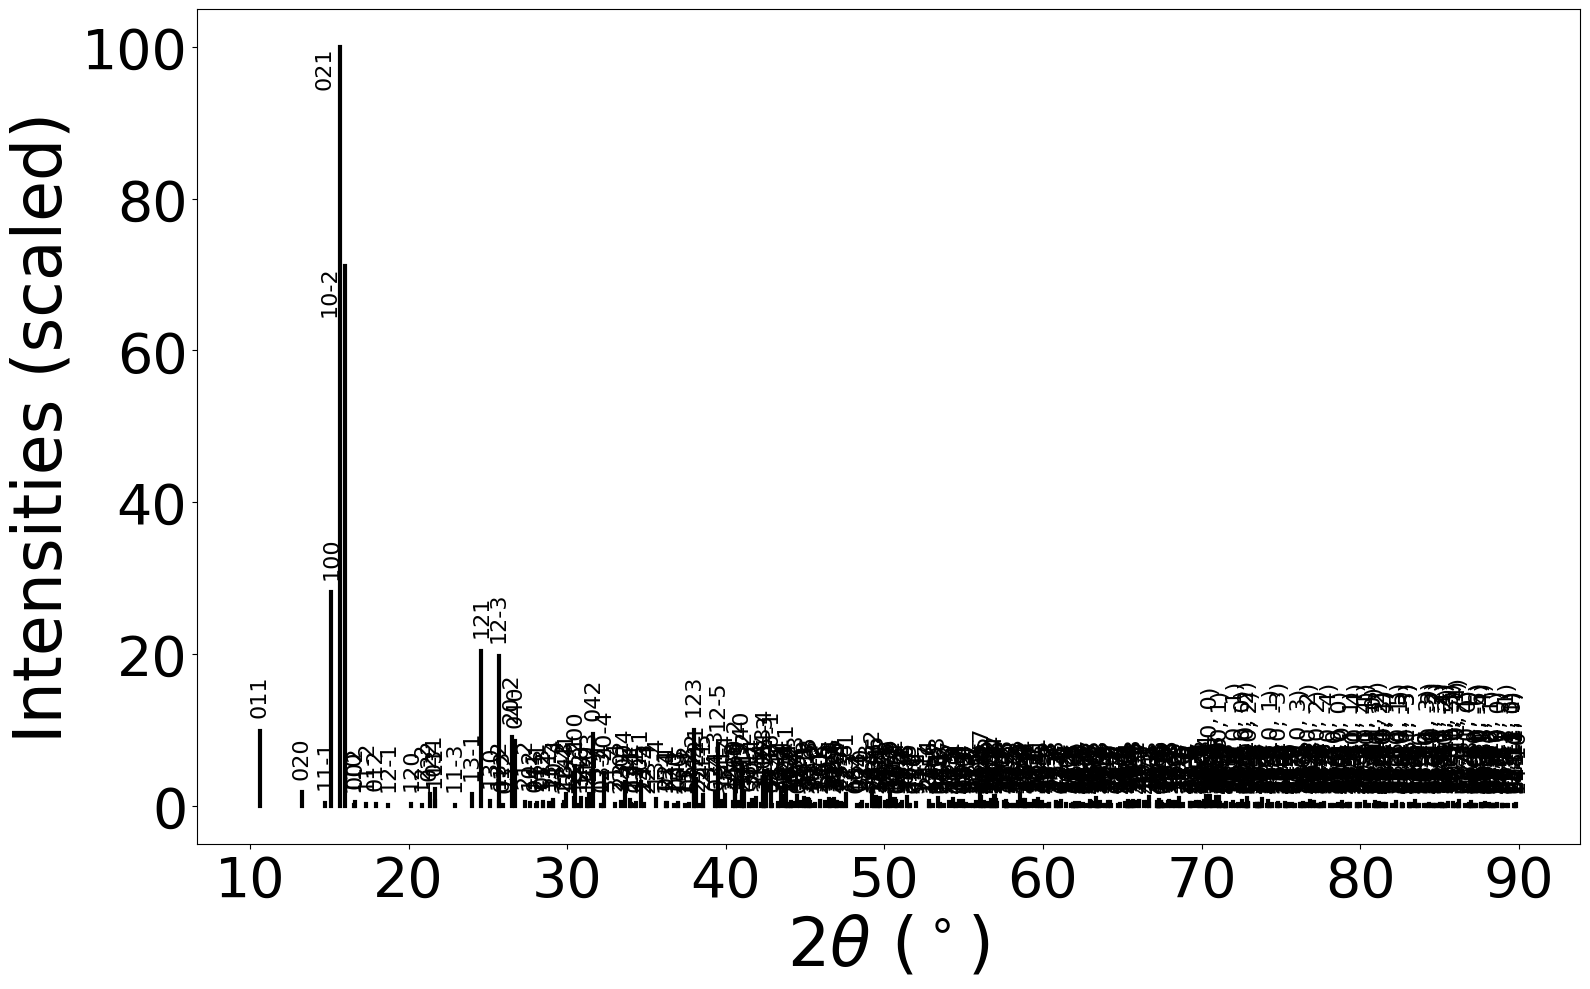

In [73]:
pattern, val = sample_NaBH.get_XRD(structure_Na)
plt.show()

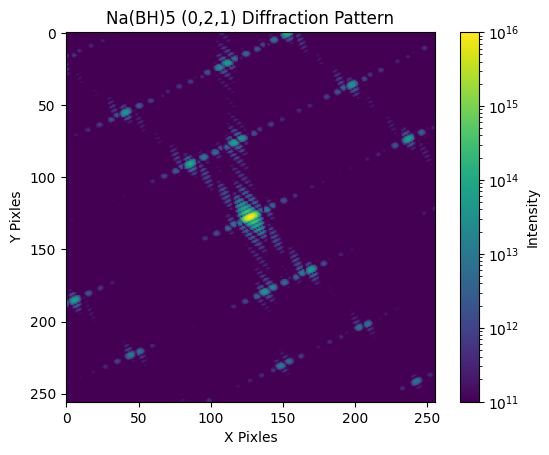

In [71]:
plt.imshow(inten_Na.cpu(),norm=colors.LogNorm(vmin = 1e+11, vmax = 1e+16)) #not sure for the norm
plt.xlabel("X Pixles")
plt.ylabel("Y Pixles")
plt.title("Na(BH)5 (0,2,1) Diffraction Pattern")
cbar = plt.colorbar()
cbar.set_label("Intensity")
plt.show()

In [97]:
sample.atom_positions[:,2].shape

torch.Size([88])